# Bag of words base model for text generation

This base model would try to predict next word in the text, treating text as a bag of words.

Based on amazon food reviews, base model should be able to reproduce (at least, get close to) those reviews with sklearn algorithms.

This notebook is based upon the previous one, "Sequential base model for text generation", and will skip some exploration and analysis.

## Load data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 393579/393579 [00:02<00:00, 171567.03it/s]


Fitting...
Predicting...


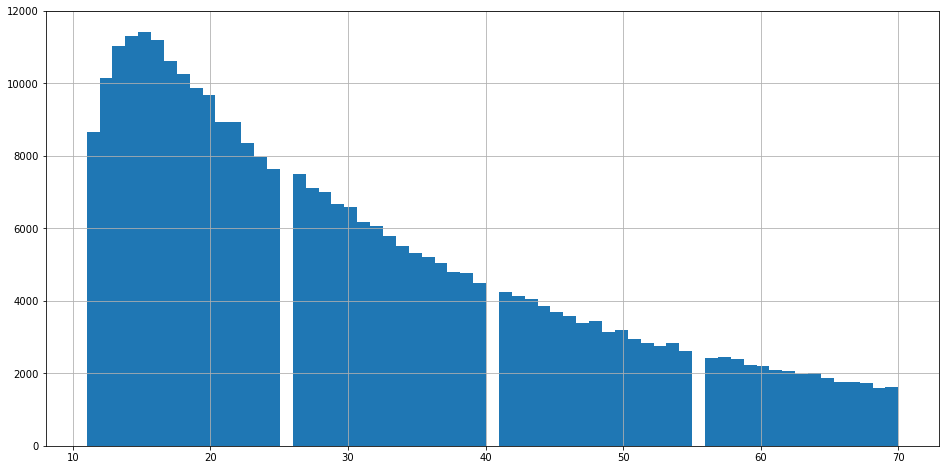

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()

text_preprocessor = TextPreprocessor(lemmatization=False)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))


from sklearn.ensemble import IsolationForest
wc_isolation_forest = IsolationForest(contamination=0.2)
wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))

print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]

import matplotlib.pyplot as plt
%matplotlib inline

_ = filtered_reviews_df['wc'].hist(bins=63, figsize=(16,8))

## Prepare data for training

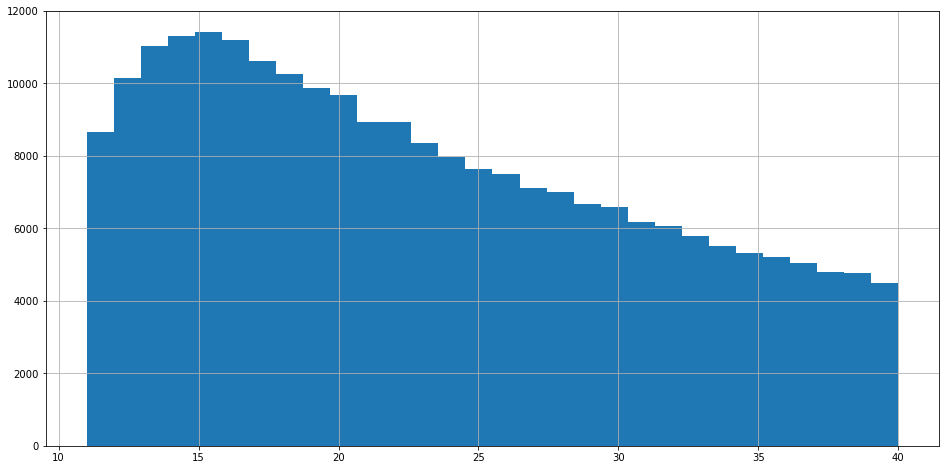

In [2]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
_ = filtered_reviews_df['wc'].hist(bins=30, figsize=(16,8))

In [3]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

100%|██████████| 611144/611144 [00:53<00:00, 11489.37it/s]


Total embeddings shape: (611143, 290)


In [5]:
windowed_data = []
for _, row in tqdm(filtered_reviews_df.iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)

def get_output(target_word):
    if target_word in text_preprocessor.stopwords:
        return -1
    if target_word not in em.embeddings_dict:
        return -1
    
    return target_word

windowed_df['output'] = windowed_df['target_word'].progress_apply(get_output)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['input'] = windowed_df['text'].progress_apply(lambda row: ' '.join([word for word in row.split() if word in em.embeddings_dict]))
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['input_wc'] = windowed_df['input'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['input_wc'] * 1.25 < windowed_df['wc'])]
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

234083it [00:15, 15510.64it/s]
100%|██████████| 4757987/4757987 [00:11<00:00, 426560.91it/s]


,wc,input_wc
count,4.731064e+06,4.731064e+06
mean,1.306154e+01,1.295745e+01
std,8.675145e+00,8.608738e+00
min,1.000000e+00,1.000000e+00
25%,6.000000e+00,6.000000e+00
50%,1.200000e+01,1.100000e+01
75%,1.900000e+01,1.900000e+01
max,3.900000e+01,3.900000e+01


### Balancing outputs

In [6]:
len(clean_seq_reviews_df['output'].unique())

41993

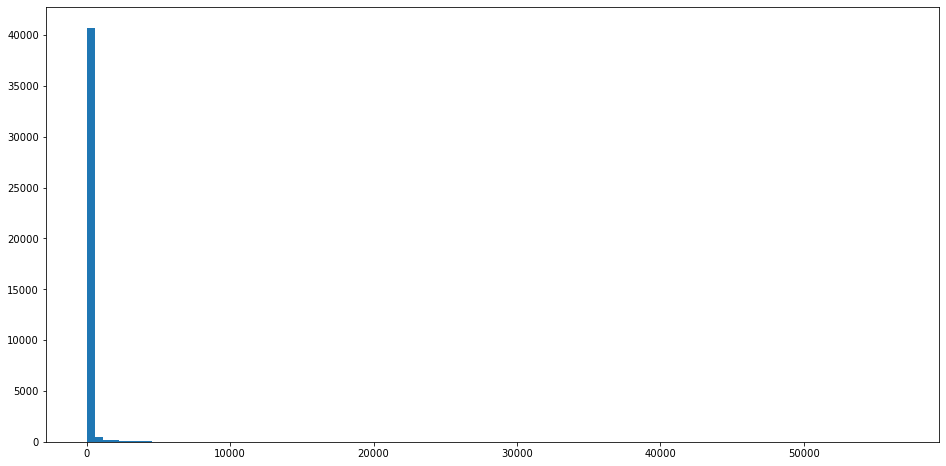

In [7]:
plt.figure(figsize=(16,8))
_ = plt.hist(clean_seq_reviews_df['output'].value_counts().values, bins=100)

In [8]:
target_words_df = clean_seq_reviews_df['target_word'].value_counts().to_frame()
target_words_df.describe()

,target_word
count,41993.000000
mean,112.663158
std,1025.705270
min,1.000000
25%,1.000000
50%,3.000000
75%,14.000000
max,56576.000000


In [11]:
max_examples = 5
balanced_df = clean_seq_reviews_df.groupby('output', group_keys=False).progress_apply(lambda group: group.sample(n=min(len(group.index), max_examples)))
balanced_df.describe()

100%|██████████| 41993/41993 [00:20<00:00, 2034.30it/s]


,wc,input_wc
count,128580.000000,128580.000000
mean,13.430176,13.300311
std,8.837624,8.755275
min,1.000000,1.000000
25%,6.000000,6.000000
50%,12.000000,12.000000
75%,19.000000,19.000000
max,39.000000,39.000000


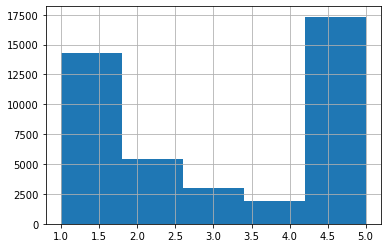

In [14]:
_ = balanced_df['output'].value_counts().hist(bins=5)

### Encode data with embeddings

In [18]:
def average_vectorizations(row):
    vectors = []
    for word in row.split():
        if word in em.embeddings_dict:
            vectors.append(em.embeddings_dict[word])
    
    result_vector = np.mean(vectors, axis=0)
    return result_vector

balanced_df['input_vector'] = balanced_df['input'].progress_apply(average_vectorizations)
balanced_df['output_vector'] = balanced_df['output'].progress_apply(average_vectorizations)

100%|██████████| 128580/128580 [00:02<00:00, 50070.67it/s]


### Train model

In [27]:
def get_arrayed_data(df_set):
    setX = np.stack(df_set['input_vector'].values, axis=0)
    setY = np.stack(df_set['output_vector'].values, axis=0)        
    return (setX, setY)

trainX, trainY = get_arrayed_data(balanced_df.sample(n=4000))
print(trainX.shape)
print(trainY.shape)

(4000, 290)
(4000, 290)


In [28]:
import time
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

regressor = SVR()
mo_regressor = MultiOutputRegressor(estimator=regressor)
start_training = time.time()

mo_regressor.fit(trainX, trainY)
end_training = time.time()
print(f'Training finished, elapsed seconds: {end_training-start_training}')

Training finished, elapsed seconds: 243.47743606567383


### Producing result

In [60]:
def generate_sequence(initial_sentence, max_generated_length=50):
    sentence = initial_sentence.lower()
    
    previous_word = []
    for i in tqdm(range(max_generated_length)):
        processed_sentence = ' '.join([word for word in sentence.split() if word in em.embeddings_dict])
        if len(processed_sentence.split()) >= max_generated_length:
            return sentence

        vectorized_sentence = average_vectorizations(processed_sentence)
        input_vector = vectorized_sentence.reshape((-1, vectorized_sentence.shape[0]))
        result = mo_regressor.predict(input_vector).reshape(em.shape)

        word_scores = em.get_words(result, k=4)
        for word_score in word_scores:
            word = word_score[0]
            
            if word not in previous_word[-3:]:
                new_word = word
                previous_word.append(word)
                break
                
        sentence += ' ' + new_word

In [61]:
generate_sequence('I have bought')

 94%|█████████▍| 47/50 [00:20<00:01,  2.29it/s]


'i have bought kaye fow mcgrath tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle tehut tnpr 98311 nethandle'

In [62]:
generate_sequence('really this was an amazing stuff for me to find')

 80%|████████  | 40/50 [00:17<00:04,  2.26it/s]


'really this was an amazing stuff for me to find tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311 tehut nethandle tnpr 98311'

In [63]:
generate_sequence('i')

 98%|█████████▊| 49/50 [00:22<00:00,  2.20it/s]


'i tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut nethandle 98311 tnpr tehut'

### Summary

Base model performs poorly, just as expected.

Comparing to sequential base model, this one performs even worse - even with filtering of generated word (in this implementation selected word was checked against last three words, and chosen only if it wasn't already used).

Flaws:
1. Model uses bagged representation of input vector, which does not represent sequential nature of a text.
2. Because embeddings encoding had to take place before training, train set was reduced to fit in memory.
3. In addition to previous, because computational powers are limited, train set was additionally reduced.
5. Train set could be balanced better.

#### Now that the base line of simple models was established, it's time to go to the real deal - recurrent neural networks.